## env

In [1]:
!nvidia-smi -L
!nvcc -V
!nvidia-smi

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-f27a01cb-fc39-23fa-8fee-6d64ced3d19e)
GPU 1: NVIDIA A100-SXM4-40GB (UUID: GPU-f511f87c-bfcb-5f43-37c3-add7d4aedceb)
GPU 2: NVIDIA A100-SXM4-40GB (UUID: GPU-41eb1c79-1ea2-60fb-d810-70e490d30be7)
GPU 3: NVIDIA A100-SXM4-40GB (UUID: GPU-eb10a3e3-073d-4fc3-6b38-dfe0d2b2e930)
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Thu Aug 18 01:57:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.85.02    Driver Version: 510.85.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|========

In [2]:
import torch
print(torch.__version__)
device = torch.device('cuda' if  torch.cuda.is_available() else 'cpu')
print(device)

/users/k21116947/miniconda3/envs/Mnet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.12.0
cuda


In [3]:
import os
# os.environ["TF_ENABLE_ONEDNN_OPTS"]=0
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import sys
sys.path.append('Code/code/')
from load_data import load_MEG_dataset
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
from torch.cuda import amp
import torch.nn.functional as F
import math
# %env CUBLAS_WORKSPACE_CONFIG=:16:8
from scipy.integrate import simps
from mne.time_frequency import psd_array_welch
from band_power import (
    bandpower_multi_bands,
    standard_scaling_sklearn,
)
import sklearn
from sklearn import preprocessing
from utils import(
    ChannelPool,
    EarlyStopping,
    SpatialAttention,
    Flatten_MEG,
    ChannelAttention,
    Concatenate,
    L1,
)
from models import LSTM1

2022-08-18 01:59:40.170945: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Mnet

## Load

In [4]:
Split = 0.90
X_train, y_train = load_MEG_dataset([str(i).zfill(3) for i in range(2,3)], mode = 'concatenate', output_format='numpy',shuffle = False, training=True, train_test_split=Split, batch_size=500)#, pca_n_components =30)
X_test, y_test = load_MEG_dataset([str(i).zfill(3) for i in range(2,3)], mode = 'concatenate', output_format='numpy',shuffle = False, training=False, train_test_split=Split, batch_size=500)#, pca_n_components =30)

X_train, X_test = (X_train-X_train.mean())/X_train.std(), (X_test-X_test.mean())/X_test.std()

X_train = X_train[:, None, ...]
X_test = X_test[:, None, ...]

# X_train=np.repeat(X_train,3,axis=1)
# X_test=np.repeat(X_test,3,axis=1)

y_train = (y_train / 2) - 1
y_test = (y_test / 2) - 1

X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)
y_train_tensors = torch.from_numpy(y_train) 
y_test_tensors = torch.from_numpy(y_test)

# y_train_tensors = F.one_hot(y_train_tensors)
# y_test_tensors = F.one_hot(y_test_tensors)
# X_train_tensors = F.interpolate(X_train_tensors, size=(272, 272), mode ='bicubic')
# X_test_tensors = F.interpolate(X_test_tensors, size=(272, 272), mode ='bicubic')

Loading subject 002
Data loaded
Subject 002 complete
--------------------------------------
Loading subject 002
Data loaded
Subject 002 complete
--------------------------------------


In [5]:
X_train_tensors.shape

torch.Size([810, 1, 272, 800])

In [6]:
X_train_tensors=X_train_tensors.cuda()
X_test_tensors=X_test_tensors.cuda()
y_train_tensors=y_train_tensors.cuda()
y_test_tensors=y_test_tensors.cuda()
print('done')

done


## band power 

In [7]:
X_train_numpy = X_train_tensors.cpu().numpy()
X_test_numpy = X_test_tensors.cpu().numpy()

X = np.swapaxes(X_train_numpy, 2, -1).squeeze()
data = X[X.shape[0]-1, 70, :]
psd_mne, freqs_mne = psd_array_welch(data, 100, 1., 70., n_per_seg=None,
                          n_overlap=0, n_jobs=1)
for low, high in [(0.5, 4), (4, 8), (8, 10), (10, 12), (12, 30),
                  (30, 70)]:
    print("processing bands (low, high) : ({},{})".format(low, high))
    # Find intersecting values in frequency vector
    idx_delta = np.logical_and(freqs_mne >= low, freqs_mne <= high)
      # Frequency resolution
    freq_res = freqs_mne[1] - freqs_mne[0]  # = 1 / 4 = 0.25

    # Compute the absolute power by approximating the area under the curve
    power = simps(psd_mne[idx_delta], dx=freq_res)
    print('Absolute power: {:.4f} uV^2'.format(power))
    
    total_power = simps(psd_mne, dx=freq_res)
    rel_power = power / total_power
    
    print('Relative power: {:.4f}'.format(rel_power))

Effective window size : 2.560 (s)
processing bands (low, high) : (0.5,4)
Absolute power: 0.2436 uV^2
Relative power: 0.2927
processing bands (low, high) : (4,8)
Absolute power: 0.0368 uV^2
Relative power: 0.0443
processing bands (low, high) : (8,10)
Absolute power: 0.0213 uV^2
Relative power: 0.0256
processing bands (low, high) : (10,12)
Absolute power: 0.0338 uV^2
Relative power: 0.0406
processing bands (low, high) : (12,30)
Absolute power: 0.3477 uV^2
Relative power: 0.4178
processing bands (low, high) : (30,70)
Absolute power: 0.1029 uV^2
Relative power: 0.1237


In [8]:
X_train_bp = np.squeeze(X_train_numpy, axis=1)
# X_train_bp = X_train_bp[: :, :, :]
X_train_bp = standard_scaling_sklearn(X_train_bp)
X_test_bp = np.squeeze(X_test_numpy, axis=1)
# X_train_bp = X_train_bp[: :, :, :]
X_test_bp = standard_scaling_sklearn(X_test_bp)
bands = [(1, 4), (4, 8), (8, 10), (10, 13), (13, 30), (30, 70)]
bp_train = bandpower_multi_bands(X_train_bp, fs=800.0, bands=bands, relative=True)
bp_test = bandpower_multi_bands(X_test_bp, fs=800.0, bands=bands, relative=True)
bp_train_tensor = torch.Tensor(bp_train).cuda()
bp_test_tensor = torch.Tensor(bp_test).cuda()

Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective window size : 0.320 (s)
Effective wind

In [9]:
bp_train_tensor.shape

torch.Size([810, 272, 6])

## Parms

In [10]:
CRED    = '\33[31m'
CGREEN  = '\33[32m'
CYELLOW = '\33[33m'
CBLUE   = '\33[34m'

## ASRCNet

In [11]:
class ASRCNet(nn.Module):
    """
        Model inspired by [Aoe at al., 10.1038/s41598-019-41500-x] integrated with bandpower.
    """
    class Showsize(nn.Module):
        def __init__(self):
            super(ASRCNet.Showsize, self).__init__()
        def forward(self, x):
            # print(x.shape)
            return x

    def __init__(self, n_times):
        """
        Args:
            n_times (int):
                n_times dimension of the input data.
        """
        super(ASRCNet, self).__init__()
        # if n_times == 501:  # TODO automatic n_times
        #     self.n_times = 12
        # elif n_times == 601:
        #     self.n_times = 18
        # elif n_times == 701:
        #     self.n_times = 24
        # else:
        #     raise ValueError(
        #         "Network can work only with n_times = 501, 601, 701 "
        #         "(epoch duration of 1., 1.2, 1.4 sec),"
        #         " got instead {}".format(n_times)
        #     )
        self.n_times = n_times
        self.spatial = nn.Sequential(
            nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(272,64), bias=False), #kernel size 204, 64
            nn.ReLU(),
            # nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, stride=(1, 1), kernel_size=(1, 16), bias=False), # kernel size 1,16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
            # nn.BatchNorm2d(64),
        )

        self.temporal = nn.Sequential(
            nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(8, 8), bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, stride=(1, 1), kernel_size=(8, 8), bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(5, 3), stride=(5, 3)),
            # nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, stride=(1, 1), kernel_size=(1, 4), bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(1, 4), bias=False), #conv6
            nn.ReLU(),
            # nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
            nn.Conv2d(64, 128, stride=(1, 1), kernel_size=(1, 2), bias=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),
            # nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, stride=(1, 1), kernel_size=(1, 2), bias=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),
            # nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
            nn.Conv2d(128, 256, stride=(1, 1), kernel_size=(1, 2), bias=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),
            # nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, stride=(1, 1), kernel_size=(1, 2), bias=False), #conv10
            nn.ReLU(),
            nn.Dropout2d(p=0.3),
            # nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
        )

        # self.attention = nn.Sequential(
        #     ChannelAttention([None, 256, 64, self.n_times]),
        #     SpatialAttention(),
        # )

        self.concatenate = Concatenate()

        self.flatten = Flatten_MEG()

        self.ff1 = nn.Sequential(
            # nn.Linear(256 * 26 * self.n_times + 272 * 6, 1024),
            nn.Linear(32352, 1024),
            # nn.BatchNorm1d(num_features=1024),
            nn.ReLU(),
            self.Showsize(),
            nn.Linear(1024, 1024),
            # nn.BatchNorm1d(num_features=1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            self.Showsize(),
        )
        self.ff2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024 , 14),
        )
        self.softmax = nn.Softmax(dim =1)

    def forward(self, x, pb):
        x = self.spatial(x)
        x = torch.transpose(x, 1, 2)
        x = self.temporal(x)
        # x = self.attention(x)
        x = self.concatenate(x, pb)
        x = self.ff1(self.flatten(x))
        x = self.ff2(x)
        x = self.softmax(x)

        return x.squeeze(1)

In [12]:
class LSTM2(nn.Module):
    def __init__(self, num_classes=14, input_size=800, hidden_size=2, num_layers=1, seq_length=272):
        super(LSTM2, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x,pb):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).cuda() #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).cuda()#internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [13]:
class CNN(nn.Module):
    def __init__(self):
        # super(CNN, self)._init_()
        super(CNN, self).__init__()
        self.n_classes = 14
        n_classes =14
        self.conv1 = nn.Sequential(
          nn.Conv2d(
              in_channels=1,
              out_channels=32,
              kernel_size=3,
              stride=1,
              padding=1,
          ),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.conv2 = nn.Sequential(
          nn.Conv2d(32,64,3,1,1),
          nn.ReLU(),
          nn.MaxPool2d (2,2),
        )
        # self.fc = nn.Linear(64*7*7,128)
        self.fc = nn.Linear(870400, 100)
        self.out = nn.Linear(100,n_classes)
        self.softmax = nn.Softmax()

    def forward(self,x,pb):
        x=self.conv1(x)
        x=self.conv2(x)
        # x=x.view(x.size(0),-1)
        x = torch.flatten(x, 1) # flatten all dimensioxns except batch
        x=self.fc(x)
        x=self.out(x)      
        # output=self.out(x)
        # return output, x
        # x=self.softmax(x)
        return x

In [14]:
model = ASRCNet(30).cuda()
# model =CNN().cuda()
print(model)

ASRCNet(
  (spatial): Sequential(
    (0): Conv2d(1, 32, kernel_size=(272, 64), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(1, 16), stride=(1, 1), bias=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (temporal): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(8, 8), stride=(1, 1), bias=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(5, 3), stride=(5, 3), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(1, 4), stride=(1, 1), bias=False)
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(1, 4), stride=(1, 1), bias=False)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(1, 2), stride=(1, 1), bias=False)
    (11): ReLU()
    (12): Dropout2d(p=0.3, inplace=False

## Train

In [15]:
BATCH_SIZE=64
num_epochs=50
train = Data.TensorDataset(X_train_tensors, y_train_tensors, bp_train_tensor)
test = Data.TensorDataset(X_test_tensors, y_test_tensors, bp_test_tensor)
train_loader = Data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = Data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

learning_rate = 0.0005
criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=0.001)
# optimizer = torch.optim.RAdam(model.parameters(), lr=1)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)

# optimizer = torch.optim.Adam([{'params': model.spatial.parameters()}, 
#                              {'params': model.temporal.parameters()},
# #                              {'params': model.attention.parameters()},
#                              {'params': model.ff1.parameters()},
#                              {'params': model.concatenate.parameters()},#,'weight_decay': 0.005},
#                              {'params': model.ff2.parameters(), 'weight_decay': 0.005}], lr=learning_rate)#, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')

In [16]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
summary_writer = SummaryWriter(f'./models/test')
# valid_loss = []
running_loss = 0
door_for_test = 1
model.train()
for epoch in range(num_epochs):  # loop over the dataset multiple times
    t_loss = 0
    train_loss = []
    for i, data in enumerate(train_loader, 0):
#         get the inputs; data is a list of [inputs, labels]
        inputs, labels, bp = data #, bp
        # inputs = inputs.squeeze(1)
        # print(inputs.shape)
        inputs, labels, bp = inputs.to(device), labels.type(torch.LongTensor).to(device), bp.to(device)# , bp  , bp.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs,bp)
        # print(outputs)
        with torch.autocast('cuda'):
        # loss = criterion(outputs, torch.tensor(labels).cuda())
            loss = criterion(outputs, labels)
#         l2_lambda = 0.001
#         l2_reg = torch.tensor(0.).cuda()
#         for param in model.parameters():
#             l2_reg += torch.norm(param)
#         loss += l2_lambda * l2_reg
        
        # l1_lambda = 0.001
        # l1_norm = sum(torch.linalg.norm(p, 1) for p in model.parameters())
        # # l2_norm = sum(torch.linalg.norm(p, 2) for p in model.parameters())
        # loss = loss + l1_lambda * l1_norm
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2, error_if_nonfinite=True)
        optimizer.step()
        t_loss += loss.item()
        # print(t_loss)
        train_loss.append(np.mean(t_loss))
    
    
    if epoch % 1 == 0:
        # if i % (math.ceil(900*Split/BATCH_SIZE)-1) == 0 and i !=0:
        print(CRED+ f'[{epoch + 1}, {i + 1}] trainning loss: {train_loss[-1]}'+ CRED)
    summary_writer.add_scalar('train_loss', train_loss[-1], epoch)
    
    if door_for_test == 1:
        if epoch % 1 == 0:
            # model.eval()
            valid_loss = []
            acc = []
            va_loss = 0
            for i, data in enumerate(test_loader, 0):
                i_list = []
                i_list.append(i)
                val_x, val_y, bp = data #, bp 
                # val_x = val_x.squeeze(1)
                val_x, val_y, bp = val_x.to(device), val_y.type(torch.LongTensor).to(device), bp.to(device)#, bp.to(device) #, bp
                Testoutput = model(val_x, bp)# , bp
                # v_loss = criterion(Testoutput, val_y, torch.Tensor(Testoutput.size(0)).cuda().fill_(1.0))
                v_loss = criterion(Testoutput, val_y) #loss
                va_loss += v_loss.item()
                valid_loss.append(np.mean(va_loss))
                # if i = i_list[-1]:    # print every first
                _, predicted = torch.max(Testoutput,1)
                labels = val_y.cpu()
                predicted = predicted.cpu()
                mean_accuracy = accuracy_score(labels[labels != 99], predicted[predicted != 99])
                acc.append(np.mean(mean_accuracy))
            print(CGREEN+f'[{epoch + 1}, {i + 1}] valid_loss: {valid_loss[-1]} Acc: {acc[-1]}'+CGREEN)
            # model.train()
        summary_writer.add_scalar('valid_loss', valid_loss[-1], epoch)
    # scheduler.step(acc[-1])

  # if epoch % 1 == 0:
  #   GETcorrectnumber(train_loader,CYELLOW)      
  #   GETcorrectnumber(test_loader,CBLUE)
  # aoemnet.train()
    early_stopping = EarlyStopping(patience=10, verbose=True)
    early_stopping(valid_loss[-1], model)

    if early_stopping.early_stop:
        print("Early stopping!")
        break

print('Finished Training')

[1, 13] trainning loss: 34.30913329124451
[1, 2] valid_loss: 5.278563976287842 Acc: 0.07692307692307693
Validation loss decreased (inf --> 5.2786).  Saving model ...
[2, 13] trainning loss: 34.304417848587036
[2, 2] valid_loss: 5.279199123382568 Acc: 0.11538461538461539
Validation loss decreased (inf --> 5.2792).  Saving model ...
[3, 13] trainning loss: 34.308826208114624
[3, 2] valid_loss: 5.280523300170898 Acc: 0.07692307692307693
Validation loss decreased (inf --> 5.2805).  Saving model ...
[4, 13] trainning loss: 34.30201745033264
[4, 2] valid_loss: 5.2812182903289795 Acc: 0.0
Validation loss decreased (inf --> 5.2812).  Saving model ...
[5, 13] trainning loss: 34.30095672607422
[5, 2] valid_loss: 5.281353235244751 Acc: 0.07692307692307693
Validation loss decreased (inf --> 5.2814).  Saving model ...
[6, 13] trainning loss: 34.23856806755066
[6, 2] valid_loss: 5.276998996734619 Acc: 0.038461538461538464
Validation loss decreased (inf --> 5.2770).  Saving model ...
[7, 13] trainnin

In [17]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
|  spatial.0.weight  |   557056   |
|  spatial.2.weight  |   32768    |
| temporal.0.weight  |    2048    |
| temporal.2.weight  |   65536    |
| temporal.5.weight  |    8192    |
| temporal.7.weight  |   16384    |
| temporal.10.weight |   16384    |
| temporal.13.weight |   32768    |
| temporal.17.weight |   65536    |
| temporal.20.weight |   131072   |
|    ff1.0.weight    |  33128448  |
|     ff1.0.bias     |    1024    |
|    ff1.3.weight    |  1048576   |
|     ff1.3.bias     |    1024    |
|    ff2.1.weight    |   14336    |
|     ff2.1.bias     |     14     |
+--------------------+------------+
Total Trainable Params: 35121166


35121166

Confusion matrix and mean accuracy

Mean accuracy = 0.07777777777777778


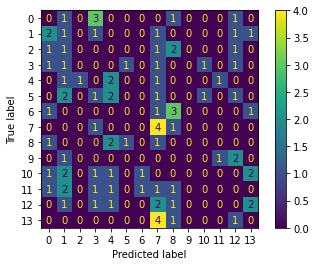

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
confusion_matrix_test_loader = Data.DataLoader(test, batch_size = 90, shuffle = False)
with torch.no_grad():
    list_mean_accuracy = []
    for i, data in enumerate(confusion_matrix_test_loader, 0):
        inputs, labels, bp = data
        # inputs = inputs.squeeze(1)
        inputs, labels, bp = inputs.to(device), labels.type(torch.LongTensor).to(device), bp.to(device)
        # inputs, labels = data
        # inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)
        outputs = model(inputs, bp)
        # outputs = model(inputs)
#         optimizer.step()          
        _, predicted = torch.max(outputs,1)
        # predicted = torch.max(outputs)
        labels = labels.cpu()
        predicted = predicted.cpu()
        labels = labels.numpy()
        predicted = predicted.numpy()
        # mean_conf_mat = confusion_matrix(labels, predicted)
        # mean_accuracy = accuracy_score(labels[labels != 99], predicted[predicted != 99])
        # mean_conf_mat = mean_conf_mat.astype('float') / mean_conf_mat.sum(axis=1)  # normalise
        mean_conf_mat = confusion_matrix(labels, predicted)
        mean_accuracy = accuracy_score(labels[labels != 99], predicted[predicted != 99])
        mean_conf_mat = mean_conf_mat.astype('float') / mean_conf_mat.sum(axis=1) 
        list_mean_accuracy.append(mean_accuracy)
        print("Mean accuracy = {0}".format(mean_accuracy))
        ConfusionMatrixDisplay.from_predictions(labels, predicted)
        # plt.savefig('/content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates/save_folder/fig-{}.png'.format(session_id), dpi=600)
        plt.show()

In [26]:
# !rm -rf /logs/ # clear logs
# if 'google.colab' in str(get_ipython()): # tensor board
%load_ext tensorboard  
# %reload_ext tensorboard
# %tensorboard --logdir logs
%tensorboard --bind_all --logdir=./models/test
# %tensorboard --host 0.0.0.0 --logdir=./models/test

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [27]:
%tensorboard --logdir=/path/to/logs

## Save

In [20]:
# import hiddenlayer as hl

# transforms = [ hl.transforms.Prune('Constant') ] # Removes Constant nodes from graph.

# graph = hl.build_graph(model, torch.zeros(64,1,272,800).cuda())
# graph.theme = hl.graph.THEMES['blue'].copy()
# graph.save('ASRCnet_hiddenlayer', format='png')

# from torchviz import make_dot
# x = torch.randn(64, 1, 272, 800).requires_grad_(True).cuda() # 定义一个网络的输入值
# y = model(x)    # 获取网络的预测值
# # y = y.cuda()
# MyConvNetVis = make_dot(y)#, params=dict(list(model.named_parameters()) + [('x', x)]))
# MyConvNetVis.format = "png"
# # 指定文件生成的文件夹
# MyConvNetVis.directory = "data"
# # 生成文件
# MyConvNetVis.view()
# inputs.shape